# ATMO 5331 - Homework 2 - Fall 2021
## Due 16 Sep, 2021

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not undersand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring there is an even contribution by your partner.

In [1]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

**Question 1**

Grab the [WGS84 implementation manual](https://www.icao.int/safety/pbn/documentation/eurocontrol/eurocontrol%20wgs%2084%20implementation%20manual.pdf), and implement a translation from geodetic latitude, longitude, and altitude (referenced to the WGS84 ellisoid) to the local XYZ cartesian system used for WGS84.

Use part 1 of Helmert's formula on p. 81 (Appendix E), and refer to Fig. B-6 in Appendix B (p. 70) for information about the coordinate system notation.

Careful with degrees and radians.

Compare your results to what you get when using the `proj4` library. This library has its origins in public domain code written by the USGS, and is used in many open source packages, including the QGIS system. For easy use of the `proj4` library, you can use the [helper routines in coordinateSystems.py](https://github.com/deeplycloudy/lmatools/blob/minvaluegrids/lmatools/coordinateSystems.py) from my `lmatools` package. Just copy that file into the same directory as this notebook.

You set up a coordinate system transform object as shown below. It defaults to a WGS84 ellipsoid, so we don't have to specify that. Once the coordinate system object `geo` has been created, you can reuse it withouth calling `GeographicSystem()` again. It accepts arrays of data.
```
from coordinateSystems import GeographicSystem 
geo = GeographicSystem() 
X, Y, Z = geo.toECEF(lon, lat, alt) # Use degrees
```

For your dataset, please use: 
```
import numpy as np
lat = np.array([  33.5,   1.0,   0.0,   0.0,   0.0,  10.0, -10.0]) 
lon = np.array([-101.5, -75.0, -85.0, -65.0, -75.0, -75.0, -75.0]) 
alt = np.zeros_like(lat)
```

Demonstrate that your ECEF conversion equals that provided by the coordinate system library.


In [1]:
# import and define original arrays
import numpy as np
import math
lat = np.array([  33.5,   1.0,   0.0,   0.0,   0.0,  10.0, -10.0]) 
lon = np.array([-101.5, -75.0, -85.0, -65.0, -75.0, -75.0, -75.0]) 
alt = np.zeros_like(lat)

# Transform arrays into radians from degrees as python hates them
pi = 3.1456
lat_rad = np.deg2rad(lat) 
lon_rad = np.deg2rad(lon) 


# Define additional variables and equations 
# v = a / (1 - e_squ * (sin(lat)**2))**1/2
# a = semimajor axis
# b = semiminor axis
# e = eccentricity of ellipsoid
# a = radius of earth
# e**2 = e_squ = f(2 - f)
# f = flattening of the earth f = (a - b) / a

# X = (v + alt) * cos(lat) * cos(lon)
# Y = (v + alt) * cos(lat) * sin(lon)
# Z = (v(1 - e**2) + alt) * sin(lat)

a = 6378137 #km from WGS 84, page 71 of manual
f = 1 / 298.257223563
e_squ = f * (2 - f)
v = a / ((1 - e_squ * (np.sin(lat_rad)**2))**(1/2))

X_coord = (v + alt) * np.cos(lat_rad) * np.cos(lon_rad)
Y_coord = (v + alt) * np.cos(lat_rad) * np.sin(lon_rad)
Z_coord = (v * [1 - e_squ] + alt) * np.sin(lat_rad)

# Transfering coordinates back to degrees from radians bc who understands radians
X_deg = np.rad2deg(X_coord) 
Y_deg = np.rad2deg(Y_coord)
Z_deg = np.rad2deg(Z_coord)

In [2]:
#My code fails without this in here... idk why
import sys
print(sys.path)

['/Users/nataliejtrout/Desktop/Datafields', '/Users/nataliejtrout/opt/anaconda3/lib/python38.zip', '/Users/nataliejtrout/opt/anaconda3/lib/python3.8', '/Users/nataliejtrout/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/nataliejtrout/opt/anaconda3/lib/python3.8/site-packages', '/Users/nataliejtrout/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/nataliejtrout/opt/anaconda3/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg', '/Users/nataliejtrout/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/nataliejtrout/.ipython']


In [3]:
#Put coordinates into graphics systems and transform to ECEF
from coordinateSystems import GeographicSystem 
geo = GeographicSystem() 
X, Y, Z = geo.toECEF(lon, lat, alt) # Use degrees

In [4]:
#Demonstraiting that our calculated and origninal coordinates are equal, true if they are
np.allclose(X, X_coord)
np.allclose(Y, Y_coord)

True

<span class="ecb">Is the Z coordinate the same? -2</span>

**Question 2.**

Using the `TangentPlaneCartesianSystem` class, convert the geodetic coordinates to local $(x, y, z)$. Create three tangent planes:

- A tangent plane centered at the MCOM building on the TTU campus, at the height of the ground at that location.

- A tangent plane centered at the MCOM building on the TTU campus, at the ellipsoid.

- A tangent plane directly below the GOES-East satellite at -75.0 degrees longitude.

Use `TangentPlaneCartesianSystem?` in the notebook to learn about the arguments accepted by the projection class. It has the same `.toECEF` and `.fromECEF` methods as the `GeographicSystem`.

Transform the geodetic dataset from the first problem into coordiantes with respect to each tangent plane.

You do not need to use the NAD83 locations of MCOM. They are only there to show my work on how I obtained the vertical position of MCOM in WGS84.

**a.** Using only the GOES-East tangent plane and the transformed geodetic dataset, show that the WGS84 earth shape is not spherical.

**b.** What is a rough, easily memorable rule of thumb for the number of kilometers per degree latitude?

**c.** Print out the tangent plane $(x,y,z)$ of the zeroth data point (it is a bit east of Lubbock). Explain why the differences in the coordinates of the two MCOM tangent planes make sense.

**d.** Imagine that there was no terrain, so that a radar located at MCOM was precisely on the WGS84 ellipsoid. If that radar were to scan toward the zeroth position at 0° elevation angle (assume no atmospheric refraction), how high above the ground would the beam be? Is this disance measured perpendicular to the ellipsoid or perpendicular to the tangent plane?

**e.** Transform your coordiantes back to ECEF from each tangent plane and show they're equal.

In [5]:
from coordinateSystems import TangentPlaneCartesianSystem

#Defining the coordinates of the xyz from the tangent plane
# create a new ellipsoid height. I also erased the correct heights, so thats why 983.15 is hard coded
mcom_lon, mcom_lat = -101.8803718553, 33.5818617015
mcom_alt = 957.179
mcom_alt_ellip = mcom_alt - 983.15


#for the tangent plane centered at mcom at the ellipsoid, the lat/lon are the same but we need to find a new alt 

# for the goes-east satellite
sat_lon, sat_lat = -75, 0
sat_alt = 0 # bc it's on the earths surface


<span class="ecb">`mcom_alt_ellip` is at the geoid, not the ellipsoid -1</span>

In [6]:
#defining the tangent plane centered at mcom
TPCS_center = TangentPlaneCartesianSystem(mcom_lat, mcom_lon, mcom_alt)

# defining the tangent plane centered at mcom at the ellipsoid
TPCS_ellipsoid = TangentPlaneCartesianSystem(mcom_lat, mcom_lon, mcom_alt_ellip)

# defining the tangent plane for the satellite
TPCS_Sat = TangentPlaneCartesianSystem(sat_lat, sat_lon, sat_alt) 

In [7]:
# changing the tangent plane into coordinates
# for the tangent plane centered at mcom
X_mcom, Y_mcom, Z_mcom = TPCS_center.fromECEF(X, Y, Z)

# for the tangent plane centered at mcom at height ellipsoid
XE_mcom, YE_mcom, ZE_mcom = TPCS_ellipsoid.fromECEF(X, Y, Z)

# for the satellite
X_sat, Y_sat, Z_sat = TPCS_Sat.fromECEF(X, Y, Z)

In [8]:
#a. show that ellipsoid is not a sphere
print(X_sat)
print(Y_sat)
d_X = X_sat[3] - X_sat[2]
print('The distance between X latitudes', d_X)
d_Y = Y_sat[5] - Y_sat[6]
print('The distance between Y latitudes', d_Y)
np.allclose(d_X, d_Y)


[-2.37558820e+06 -1.40916044e-06 -1.10755187e+06  1.10755187e+06
  0.00000000e+00 -1.40418937e-05  1.39987254e-05]
[ 3.50033429e+06  1.10568775e+05 -1.41136132e-05  1.41131363e-05
  0.00000000e+00  1.10024855e+06 -1.10024855e+06]
The distance between X latitudes 2215103.7339200447
The distance between Y latitudes 2200497.0954707228


False

What we did here is looking at the difference between points when the coordninate does not change in its respective array. This
proves that the ellipsoid is not a sphere as if it was, the differences in the differences would be the same. 

b. an easy way to remember it is that there is about 111 km between each degree of latitude. I remember it as Kansas
is 3 degrees and 333km tall. So dividing by three give 111km per degree. 

In [9]:
#c. Print out the tangent plane  (𝑥,𝑦,𝑧) of the zeroth data point (it is a bit east of Lubbock). Explain why the 
#  differences in the coordinates of the two MCOM tangent planes make sense.

print('the mcom point centered on mcom (tangent plane one)',X_mcom[0])
print('the mcom point centered on mcom at ellipsoid height',XE_mcom[0])

the mcom point centered on mcom (tangent plane one) 35344.860726469895
the mcom point centered on mcom at ellipsoid height 35344.86072646976


They are slightly different as when something is reflected back to the surface, it is just a bit off, but in the grand scheme
of things, this should be neglectable 

<span class="ecb">What about the other coordinates? -1</span>

In [10]:
#d. Imagine that there was no terrain, so that a radar located at MCOM was precisely on the WGS84 ellipsoid. If that 
#  radar were to scan toward the zeroth position at 0° elevation angle (assume no atmospheric refraction), how high above the 
#  ground would the beam be? Is this disance measured perpendicular to the ellipsoid or perpendicular to the tangent plane?

print(np.abs(ZE_mcom[0]), 'meters')

78.2567358325905 meters


<span class="ecb">Value is a bit low, and no statement about direction of the measurement -2</span>

In [11]:
#e. Transform your coordiantes back to ECEF from each tangent plane and show they're equal.
X_mcom_to_ECEF, Y_mcom_to_ECEF, Z_mcom_to_ECEF = TPCS_center.toECEF(X_mcom, Y_mcom, Z_mcom)
XE_mcom_to_ECEF, YE_mcom_to_ECEF, ZE_mcom_to_ECEF = TPCS_ellipsoid.toECEF(XE_mcom, YE_mcom, ZE_mcom)
X_sat_to_ECEF, Y_sat_to_ECEF, Z_sat_to_ECEF = TPCS_Sat.toECEF(X_sat, Y_sat, Z_sat)

print(np.allclose(X_mcom_to_ECEF, XE_mcom_to_ECEF))
print(np.allclose(Y_mcom_to_ECEF, YE_mcom_to_ECEF))
print(np.allclose(Z_mcom_to_ECEF, ZE_mcom_to_ECEF))

True
True
True


**Question 3** Use the `GeostationaryFixedGridSystem` to define two more coordiante transformations for the GOES-East and GOES-West locations at -75.0 and -135.0 degrees longitude.

Use `GeostationaryFixedGridSystem?` in the notebook to learn about the arguments accepted by the projection class.

Convert the dataset to fixed grid coordinates.

For more on fixed grid coordiantes, you can read the [GOES-R L1b product users' guide](https://www.goes-r.gov/resources/docs.html) and [my own description of GOES fixed grid coordiantes](https://github.com/deeplycloudy/glmtools/blob/master/docs/fixedgridguide.md), a.k.a. [the geostationary projection](https://proj.org/operations/projections/geos.html).



In [12]:
GeostationaryFixedGridSystem?

Object `GeostationaryFixedGridSystem` not found.


In [13]:
from coordinateSystems import GeostationaryFixedGridSystem

# defining the coordinates of the satellites
goes_east_lon, goes_east_lat = -75.0, 0
goes_west_lon, goes_west_lat = -135.0, 0
goes_east_alt = 0
goes_west_alt = 0

In [14]:
#defining the tangent plane at Goes East
goeseast = GeostationaryFixedGridSystem(goes_east_lat, goes_east_lon)

In [15]:
#defining the tangent plane at Goes West
goeswest = GeostationaryFixedGridSystem(goes_west_lon, goes_west_lat)

Side note: As we know, my code was really funky for this assignment. So when I was defining the tangent planes here, you can 
    see that my lats and lons are different for each plane. Funny enough, I got errors for each of them when I reversed them. I
    think this caused problems further down the homework which I will discuss. 

<span class="ecb">Yeah, that's strange; should be lon, lat. -1. The help text `GeostationaryFixedGridSystem?` will only work after import</span>

**Question 4.** Make a plot of the east and north coordinate data from the lon/lat, 3 tangent plane, and two GOES fixed grid projections, for a total of 6 plots.

Transform and plot three more locations (your hometown, your undergraduate institution's location, and the farthest you've been from home).

Does everything make sense? If not, what do you observe? Offer a plausible explanation for what might have happened.

Label the coordinates with the altitude of the point in that coordinate reference system.

[-127446.87270359 -300603.48113809  326833.49889538] [4770900.34485471 4735878.23799926 5941663.40107843] [4218000.36926492 4248776.26570946 2288131.42062819]


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


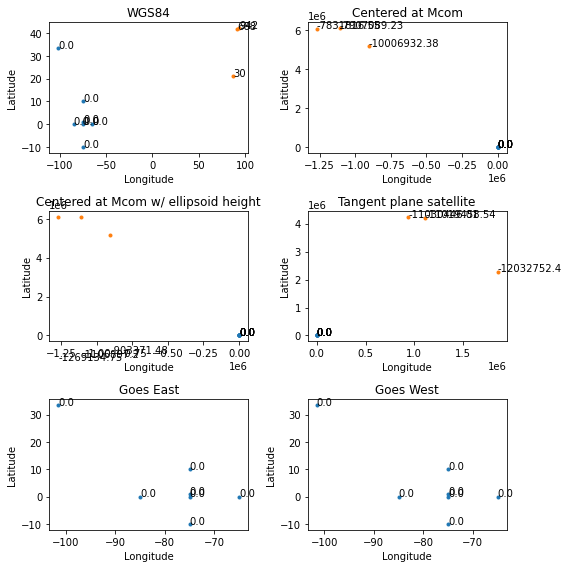

In [16]:
#specify coordinates and transfer them to ECEF
#Points: Iowa City Iowa, Ames Iowa, Cancun Mexico
loc_lon = 91.5302, 93.6319, 86.8515
loc_lat = 41.6611, 42.0308, 21.1619
loc_alt = 668, 942, 30
loc_ECEF_lon, loc_ECEF_lat, loc_ECEF_alt= geo.toECEF(loc_lon, loc_lat, loc_alt)
print(loc_ECEF_lon, loc_ECEF_lat, loc_ECEF_alt)

#For the tangent plane centered at Mcom
x_plot_mcom1, y_plot_mcom1, z_plot_mcom1 = TPCS_center.fromECEF(loc_ECEF_lon, loc_ECEF_lat, loc_ECEF_alt)
x_plot_mcom = np.round_(x_plot_mcom1, decimals = 2)
y_plot_mcom = np.round_(y_plot_mcom1, decimals = 2)
z_plot_mcom = np.round_(z_plot_mcom1, decimals = 2)

#For the tangent plane centered at Mcom at height of ellipsoid
x_plot_mcomE1, y_plot_mcomE1, z_plot_mcomE1 = TPCS_ellipsoid.fromECEF(loc_ECEF_lon, loc_ECEF_lat, loc_ECEF_alt)
x_plot_mcomE = np.round_(x_plot_mcomE1, decimals = 2)
y_plot_mcomE = np.round_(y_plot_mcomE1, decimals = 2)
z_plot_mcomE = np.round_(z_plot_mcomE1, decimals = 2)

#For the tangent plane at the satellite
x_plot_sat1, y_plot_sat1, z_plot_sat1 = TPCS_Sat.fromECEF(loc_ECEF_lon, loc_ECEF_lat, loc_ECEF_alt)
x_plot_sat = np.round_(x_plot_sat1, decimals = 2)
y_plot_sat = np.round_(y_plot_sat1, decimals = 2)
z_plot_sat = np.round_(z_plot_sat1, decimals = 2)

#For the tangent plane at goes east
x_plot_east1, y_plot_east1, z_plot_east1 = goeseast.fromECEF(loc_ECEF_lon, loc_ECEF_lat, loc_ECEF_alt)
x_plot_east = np.round_(x_plot_east1, decimals = 2)
y_plot_east = np.round_(y_plot_east1, decimals = 2)
z_plot_east = np.round_(z_plot_east1, decimals = 2)

#For the tangent plane at goes west
x_plot_west1, y_plot_west1, z_plot_west1 = goeswest.fromECEF(loc_ECEF_lon, loc_ECEF_lat, loc_ECEF_alt)
x_plot_west = np.round_(x_plot_west1, decimals = 2)
y_plot_west = np.round_(y_plot_west1, decimals = 2)
z_plot_west = np.round_(z_plot_west1, decimals = 2)


#A few extra things so matplot doesnt hate me
%matplotlib notebook
%matplotlib inline 
import matplotlib.pyplot as plt
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8,8))

#East and north coordinate
axes[0,0].plot
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')
axes[0,0].set_title('WGS84')
axes[0,0].plot(lon, lat, marker='.', linestyle='none')
axes[0,0].plot(loc_lon, loc_lat, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(lon, lat, alt):
    axes[0,0].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(loc_lon, loc_lat, loc_alt):
    axes[0,0].text(tlon, tlat, tlabel)

#Tangent plane centered at Mcom
axes[0,1].plot
axes[0,1].set_xlabel('Longitude')
axes[0,1].set_ylabel('Latitude')
axes[0,1].set_title('Centered at Mcom')
axes[0,1].plot(lon, lat, marker='.', linestyle='none')
axes[0,1].plot(x_plot_mcom, y_plot_mcom, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(lon, lat, alt):
    axes[0,1].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(x_plot_mcom, y_plot_mcom, z_plot_mcom):
    axes[0,1].text(tlon, tlat, tlabel)
   

#Tangent plane centered at Mcom at alt of the ellipsoid BRO WHY IS THIS RED (I know why but I am mad)
axes[1,0].plot
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
axes[1,0].set_title('Centered at Mcom w/ ellipsoid height')
axes[1,0].plot(lon, lat, marker='.', linestyle='none')
axes[1,0].plot(x_plot_mcomE, y_plot_mcomE, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(lon, lat, alt):
    axes[1,0].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(x_plot_mcomE, x_plot_mcomE, x_plot_mcomE):
    axes[1,0].text(tlon, tlat, tlabel)

#Tangent plane plot at the satellite 
axes[1,1].plot
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel('Latitude')
axes[1,1].set_title('Tangent plane satellite')
axes[1,1].plot(lon, lat, marker='.', linestyle='none')
axes[1,1].plot(x_plot_sat, y_plot_sat, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(lon, lat, alt):
    axes[1,1].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(x_plot_sat, y_plot_sat, z_plot_sat):
    axes[1,1].text(tlon, tlat, tlabel)  

#Tangent plane plot at the goes east satellite
axes[2,0].plot
axes[2,0].set_xlabel('Longitude')
axes[2,0].set_ylabel('Latitude')
axes[2,0].set_title('Goes East')
axes[2,0].plot(lon, lat, marker='.', linestyle='none')
axes[2,0].plot(x_plot_east, y_plot_east, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(lon, lat, alt):
    axes[2,0].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(x_plot_east, y_plot_east, z_plot_east):
    axes[2,0].text(tlon, tlat, tlabel)
     
#Tangent plane at goes west
axes[2,1].plot
axes[2,1].set_xlabel('Longitude')
axes[2,1].set_ylabel('Latitude')
axes[2,1].set_title('Goes West')
axes[2,1].plot(lon, lat, marker='.', linestyle='none')
axes[2,1].plot(x_plot_west, y_plot_west, marker='.', linestyle='none')
for tlon, tlat, tlabel in zip(lon, lat, alt):
    axes[2,1].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(x_plot_west, y_plot_west, z_plot_west):
    axes[2,1].text(tlon, tlat, tlabel)
fig.tight_layout()

I think it makes sense? Or at least for the first few plots. I am a bit worried about my goes plots, as they are the same and 
I am pretty sure they should be opposite. As I mentioned earlier, I think this is because the way I defined it? But otherwise, the plots should be "different" as they are based off of different tangent planes. I also rounded to try to make it a bit cleaner. 

<span class="ecb">Your commentary on the comment color! 🤣 I don't actually know why, and would love to hear your explanation.</span>

<span class="ecb">The first couple plots do make sense as defined, though your western hemisphere locations of interest should have negative longitude. -1 The GOES coordinates should be fixed grid angles, not lon, lat. -1. You should also notice some differences for fixed grid points that are on the other side of the hemisphere outside the field of view of the satllite, and their very large negative altitudes in fixed grid coordinates. Please debug further to understand. -2 </span>

Text(0.5, 0, 'ECEF Z (m)')

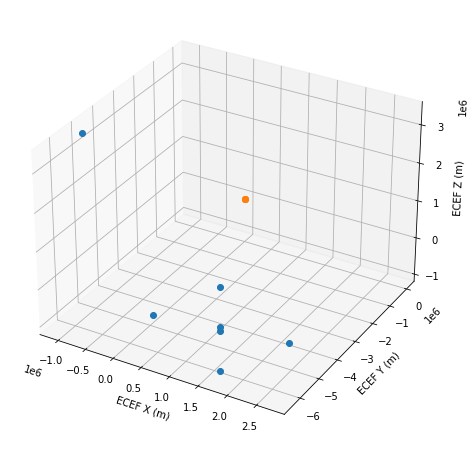

In [17]:
# BONUS! Make a 3D plot of all locations. 
# Try to imagine the curved earth surface on which they reside.
# This part is not graded, but might be useful to you.

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X, Y, Z, marker='o', linestyle='none') # original locations
ax.plot(loc_lon, loc_lat, loc_alt, marker='o', linestyle='none') # personal locations
ax.set_xlabel('ECEF X (m)')
ax.set_ylabel('ECEF Y (m)')
ax.set_zlabel('ECEF Z (m)')
#ax.set_aspect('equal')

**5.** Using the arrays you created in the previous assignment, create a `pcolormesh` plot of the data in geostationary coordinates from both the GOES East and GOES West positions. (15 pts.)

(6, 8)


Text(0.5, 1.0, 'Goes West')

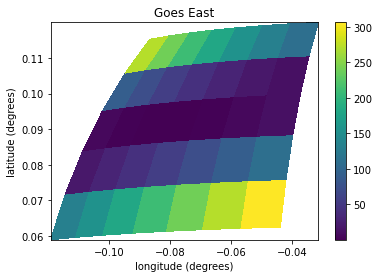

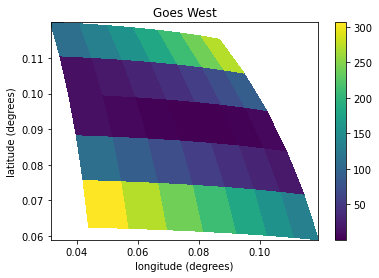

In [18]:
#Defining the variables from HW 1
mcom_lon_HW1, mcom_lat_HW1 = -101.8803718553, 33.5818617015
mcom_alt_HW1 = 957.179

#Here, we define the shape of the array, and the coordinates for two 1D arrays centered on MCom
nlon = 7
nlat = 5
dlon, dlat = 5.0, 5.0
d = (np.arange(nlon*nlat) - (nlon*nlat/2.0))**2.0
d.shape = (nlat, nlon)

#definging the arrays
lonHW2 = np.array([mcom_lon_HW1 - 15, mcom_lon_HW1 -10 , mcom_lon_HW1 - 5, mcom_lon_HW1, mcom_lon_HW1 + 5, mcom_lon_HW1
                + 10, mcom_lon_HW1 + 15])
latHW2 = np.array([mcom_lat_HW1 - 10, mcom_lat_HW1 - 5, mcom_lat_HW1, mcom_lat_HW1 + 5, mcom_lat_HW1 + 10])

#defining our fuction to create a new array for the original arrays that will have the lon/lat points as the center of the
#  the pixels and not the edges
def centers_to_edges_1d(x):
    dis = 2.5
    return np.arange(min(x) - dis, max(x) + 2*dis, 2*dis)
 
#Using our function, defining our new edges and then meshing them together on one grid. In addition, we will make a array of 
#  zeros that will be the same size as our meshed grid to use for the height later
lon_edge = centers_to_edges_1d(lonHW2)
lat_edge = centers_to_edges_1d(latHW2)

lon_edge_2d, lat_edge_2d = np.meshgrid(lon_edge, lat_edge)
print(np.shape(lon_edge_2d))

rows, cols = (6, 8)
alt_array = np.zeros_like(lon_edge_2d)

#Transforming our arrays to ECEF for the geographic system transformation and then from ECEF to create our coordniates for our
#  goes projections. 
XECEF, YECEF, ZECEF = geo.toECEF(lon_edge_2d, lat_edge_2d, alt_array)

x_geo_east, y_geo_east, z_geo_east = goeswest.fromECEF(YECEF, XECEF, ZECEF)
x_geo_west, y_geo_west, z_geo_west = goeswest.fromECEF(XECEF, YECEF, ZECEF)


#Plotting goes east
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(x_geo_east, y_geo_east, d)
plt.colorbar(im)
ax.set_xlabel('longitude (degrees)')
ax.set_ylabel('latitude (degrees)')
ax.set_title('Goes East')

#Plotting goes west
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(x_geo_west, y_geo_west, d)
plt.colorbar(im)
ax.set_xlabel('longitude (degrees)')
ax.set_ylabel('latitude (degrees)')
ax.set_title('Goes West')

Back to our Goes problem. I did some hand wavey things to get over this problem (see the flip of coordinates when transfering from ECEF), but I know they were supposed to be mirroring eachother... So note, I think this is what they are supposed to look like but it is slightly deciving. 

<span class="ecb">Looks right in the end, though the coordinates are fised grid angles in radians -1</span>

**6.** One thing we didn't do in the previous assignment was plot in a "traditional" map projection. We'll do that now with the Azimuthal Equidistant and Gnomonic projections, centered on MCOM, as defined below. The MapProjection class has the same to/from ECEF methods, and coordinates returned are in meters relative to the center point. (15 pts.)

If you're curious, you can peruse [the full list of projections](https://proj.org/operations/projections/index.html) to see how to define others.

Create a plot of the same data in each map projection, and set the axis limits to +/- 1600 km. Do you notice any differences in the two projections?

Text(0.5, 1.0, 'Gnom')

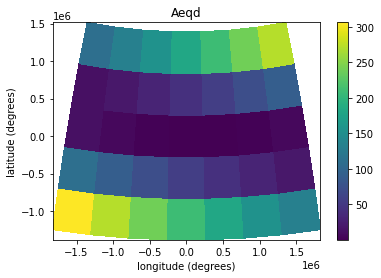

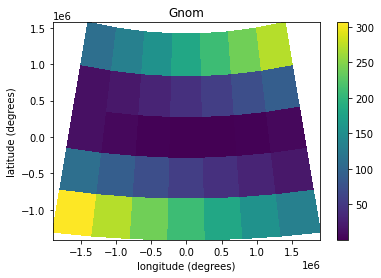

In [19]:
from coordinateSystems import MapProjection

#Definging our map projection and transforming points from ECEF, then plotting the projections
aeqd = MapProjection(projection='aeqd', lon_0=mcom_lon, lat_0=mcom_lat)
gnom = MapProjection(projection='gnom', lon_0=mcom_lon, lat_0=mcom_lat)

XECEF_aeqd, YECEF_aeqd, ZECEF_aeqd = aeqd.fromECEF(XECEF, YECEF, ZECEF)
XECEF_gnom, YECEF_gnom, ZECEF_gnom = gnom.fromECEF(XECEF, YECEF, ZECEF)

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(XECEF_aeqd, YECEF_aeqd, d)
plt.colorbar(im)
ax.set_xlabel('longitude (degrees)')
ax.set_ylabel('latitude (degrees)')
ax.set_title('Aeqd')

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(XECEF_gnom, YECEF_gnom, d)
plt.colorbar(im)
ax.set_xlabel('longitude (degrees)')
ax.set_ylabel('latitude (degrees)')
ax.set_title('Gnom')

I see a slight difference. I feel like the Aeqd plot feels more curved than the Gnom plot? Like it maybe has a different angle almost? Which would make sense as the azimuth projection is a projection that has all its points proportionally away from eachother. While the gnomonic projection is the shortest distance between two points. 

<span class="ecb">Axes are distances are in meters -1 and the min/max coordinates are a bit different, which you could notice if setting the axis limits to 1600 km -1 </span>